In [3]:
from os import path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
from tqdm.notebook import tqdm

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data")

In [213]:
session = client.load_ophys_session("M409828_13")

In [6]:
metrics = at.load_roi_metrics(remove_duplicates=False)
metrics.head()

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,spontaneous_event_mean,spontaneous_event_std,depth_chunk,depth_trunc,vol_plane,dgw_is_responsive,dgf_is_responsive,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
M409828_11_1_89,409828,1,1,1,89,True,False,False,0,NaN,...,0.000287,0.001903,0,0,1-1,False,False,-0.043955,30.681108,69.313722
M409828_11_2_0,409828,1,1,2,0,True,False,True,2,"M409828_11_2_0, M409828_11_3_2",...,0.000346,0.002629,0,0,1-2,False,False,-0.073683,61.781378,43.508462
M409828_11_2_1,409828,1,1,2,1,True,False,True,2,"M409828_11_2_1, M409828_11_3_0",...,0.000341,0.002262,0,0,1-2,True,True,-0.011145,20.539986,13.115250
M409828_11_2_2,409828,1,1,2,2,True,False,False,0,NaN,...,0.000341,0.002412,0,0,1-2,True,True,0.278888,360.000000,66.145993
M409828_11_2_4,409828,1,1,2,4,True,False,False,0,NaN,...,0.000234,0.001601,0,0,1-2,False,False,-0.100974,348.754021,307.709808


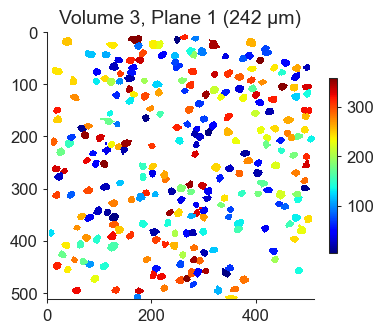

In [214]:
for plane in session.get_planes():
    depth = session.get_plane_depth(plane)
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = session.get_plane_projection_images(plane)
    valid_rois = np.where(session.is_roi_valid(plane))[0]

    fig, ax = plt.subplots(figsize=(4, 4))

    # ax.imshow(proj_de_max, cmap="gray", interpolation="nearest")
    # ax.imshow(np.ma.masked_where(~session.get_roi_image_mask(plane, valid_rois), proj_de_max), cmap="viridis", interpolation="nearest")


    all_roi_mask = None



    # ax.imshow(session.get_roi_image_mask(plane, valid_rois), interpolation="nearest")
    

    for roi in session.get_rois(plane):
        if not session.is_roi_valid(plane, roi): continue
        roi_mask = session.get_roi_image_mask(plane, roi)
        roi_idx = f"M{session.get_mouse_id()}_{session.get_column_id()}{session.get_volume_id()}_{plane}_{roi}"

        if all_roi_mask is None:
            all_roi_mask = np.nan * np.zeros_like(roi_mask, dtype=float)
        
        if metrics.at[roi_idx, "dgw_frac_responsive_trials"] >= 0.25:
            pref_dir = metrics.at[roi_idx, "dgw_pref_dir_mean"]
            
            all_roi_mask[roi_mask] = pref_dir

    # ax.imshow(np.ma.masked_where(~mask, proj_de_max), cmap="RdBu_r", interpolation="nearest")
    im = ax.imshow(all_roi_mask, cmap="jet", interpolation="nearest")
    plt.colorbar(im, fraction=0.03)

    ax.set_title(f"Volume {session.get_volume_id()}, Plane {plane} ({depth} µm)")
    fig.tight_layout()

    break

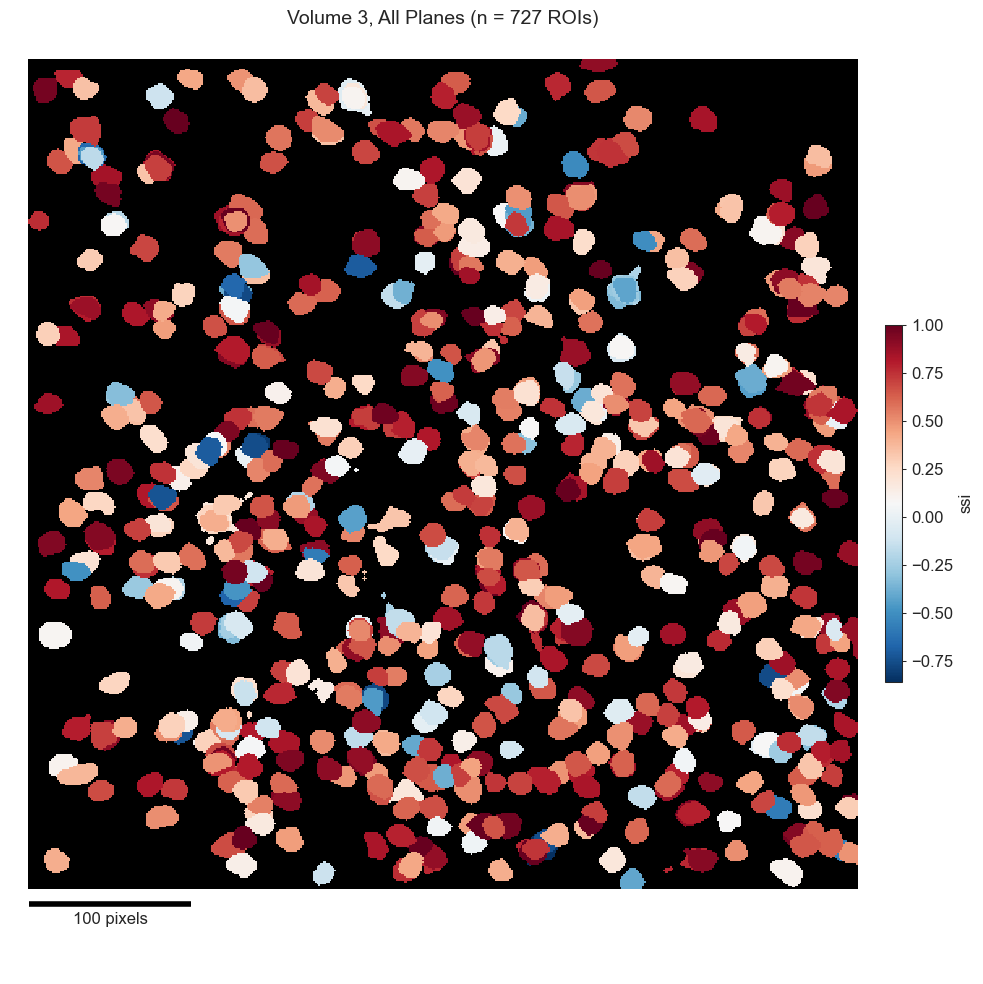

In [215]:
fig, ax = plt.subplots(figsize=(10, 10))
# metric, cmap = "depth", "plasma"
# metric, cmap = "dgw_pref_dir_mean", "jet"
# metric, cmap = "dgf_pref_dir_mean", "jet"
metric, cmap = "ssi", "RdBu_r"
all_roi_metrics_image = None
n_rois = 0

for plane in session.get_planes():
    for roi in session.get_rois(plane):
        roi_idx = f"M{session.get_mouse_id()}_{session.get_column_id()}{session.get_volume_id()}_{plane}_{roi}"
        
        if roi_idx not in metrics.index: continue
        # if metrics.at[roi_idx, "is_ignored_duplicate"]: continue

        roi_mask = session.get_roi_image_mask(plane, roi)

        if all_roi_metrics_image is None:
            all_roi_metrics_image = np.nan * np.zeros_like(roi_mask, dtype=float)
        
        if metric == "depth":
            all_roi_metrics_image[roi_mask] = metrics.at[roi_idx, metric]
            n_rois += 1
        else:
            if metrics.at[roi_idx, "dgw_frac_responsive_trials"] >= 0.5:
                all_roi_metrics_image[roi_mask] = metrics.at[roi_idx, metric]
                n_rois += 1

cmap = plt.get_cmap(cmap)
cmap.set_bad("black")

im = ax.imshow(all_roi_metrics_image, cmap=cmap, interpolation="nearest", origin="lower")
cbar = plt.colorbar(im, fraction=0.02, pad=0.01)
cbar.set_label(metric)

ax.set_title(f"Volume {session.get_volume_id()}, All Planes (n = {n_rois} ROIs)")
ax.axis("equal")
ax.axis("off")

ax.hlines(y=-10, xmin=0, xmax=100, color="black", linewidth=4)
ax.text(50, -15, "100 pixels", ha="center", va="top")

fig.tight_layout()

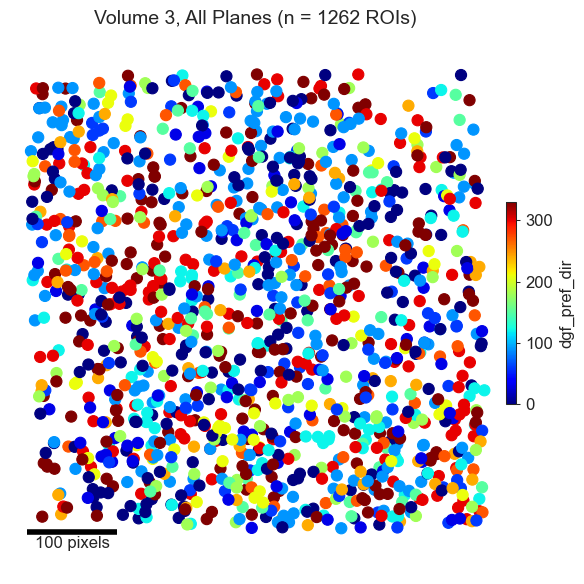

In [216]:
fig, ax = plt.subplots(figsize=(6, 6))
# metric, cmap = "dgw_pref_dir_mean", "jet"
# metric, cmap = "dgf_pref_dir_mean", "jet"
metric, cmap = "dgf_pref_dir", "jet"
# metric, cmap = "ssi", "RdBu_r"

xy, c = [], []

for plane in session.get_planes():
    for roi in session.get_rois(plane):
        roi_idx = f"M{session.get_mouse_id()}_{session.get_column_id()}{session.get_volume_id()}_{plane}_{roi}"
        
        if roi_idx not in metrics.index: continue
        if metrics.at[roi_idx, "is_ignored_duplicate"]: continue

        roi_mask = session.get_roi_image_mask(plane, roi)
        
        y_ctr, x_ctr = np.mean(np.where(roi_mask), axis=1)
        
        if metrics.at[roi_idx, "dgf_frac_responsive_trials"] >= 0.25:
            xy.append([x_ctr, y_ctr])
            c.append(metrics.at[roi_idx, metric])

xy = np.array(xy)
c = np.array(c)
pairwise_dist = scipy.spatial.distance_matrix(xy, xy)
pairwise_dist[np.tril_indices_from(pairwise_dist)] = np.nan
pairwise_dist = np.ma.masked_invalid(pairwise_dist)

sc = ax.scatter(xy[:, 0], xy[:, 1], c=c, s=8**2, cmap=cmap)
cbar = plt.colorbar(sc, fraction=0.02, pad=0.01)
cbar.set_label(metric)

ax.set_title(f"Volume {session.get_volume_id()}, All Planes (n = {len(xy)} ROIs)")
ax.axis("equal")
ax.axis("off")
ax.hlines(y=0, xmin=0, xmax=100, color="black", linewidth=4)
ax.text(50, -5, "100 pixels", ha="center", va="top")
fig.tight_layout()

# Look at local preferred direction

In [217]:
n = 512

plot_grid = np.arange(0, n, 4) + 0.5
xy_grid = np.empty((len(plot_grid)**2, 2), dtype=float)

for i, x in enumerate(plot_grid):
    idx = slice(len(plot_grid)*i, len(plot_grid)*(i+1))
    xy_grid[idx, 0] = x
    xy_grid[idx, 1] = plot_grid

grid_dists = scipy.spatial.distance_matrix(xy_grid, xy)

In [218]:
c_old = c.copy()

Text(0, 0.5, 'Count')

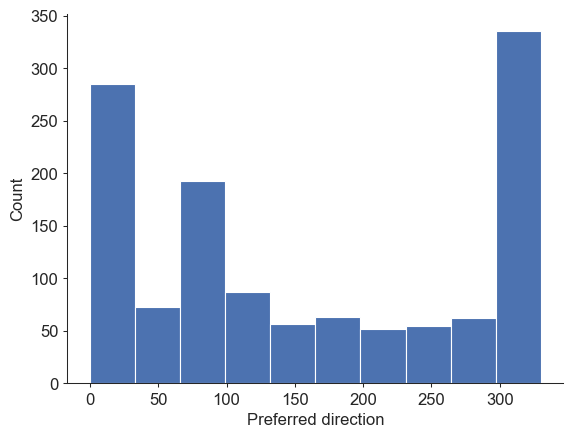

In [219]:
plt.hist(c_old)
plt.xlabel("Preferred direction")
plt.ylabel("Count")

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

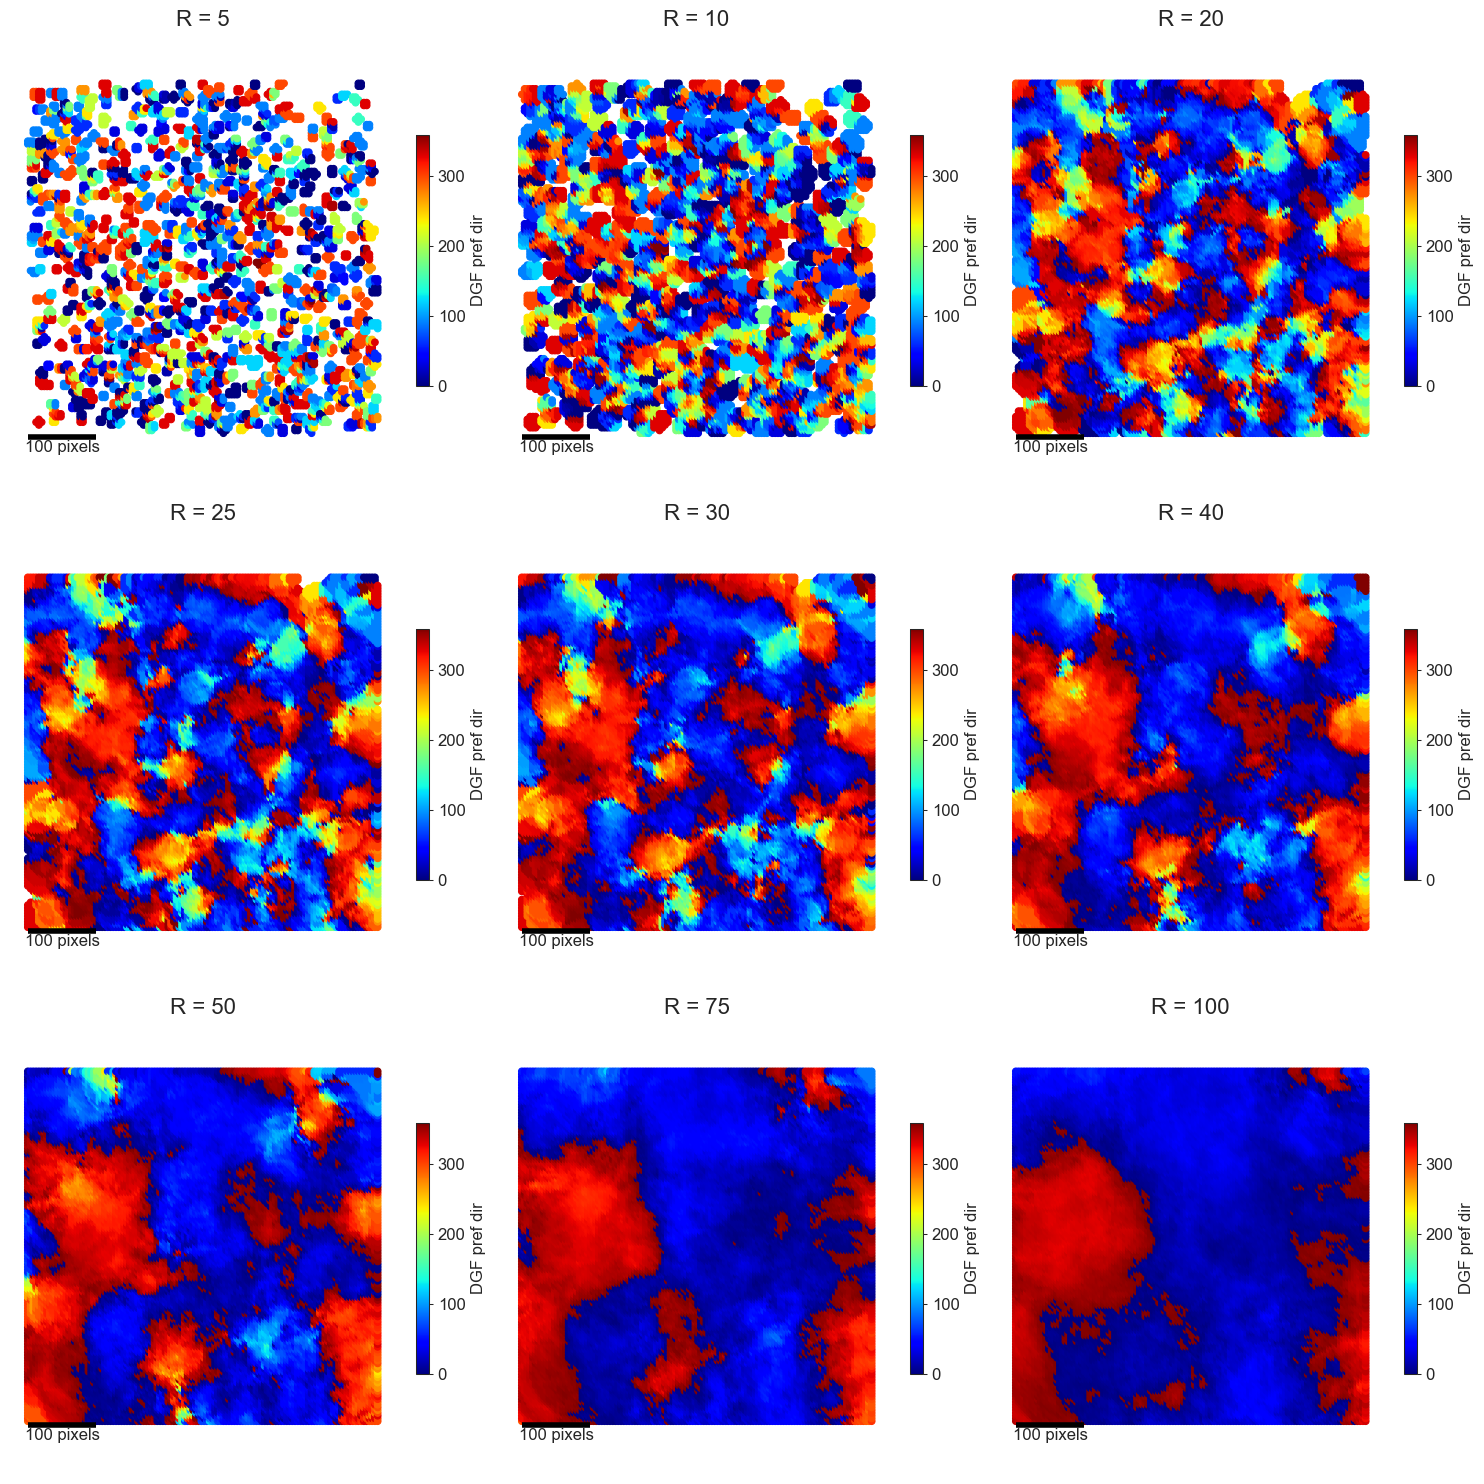

In [220]:
image = np.full((n, n), np.nan)
transparent = (1, 1, 1, 0)

fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3)
axs = axs.flatten()

for ax in axs: ax.axis("off")

# np.random.shuffle(c)
# c = np.random.uniform(low=0, high=360, size=c.shape)

for ax, r in zip(axs, [5, 10, 20, 25, 30, 40, 50, 75, 100]):
    grid_masks = grid_dists < r

    scatter_colors = []

    for i in tqdm(range(len(xy_grid))):
        xy_plot = xy_grid[i]
        nearby_points_mask = grid_masks[i]

        if nearby_points_mask.sum() == 0:
            scatter_colors.append(np.nan)
            continue

        # Take vector mean nearby
        vec_avg = 0
        for pref_dir_deg in c[nearby_points_mask]:
            pref_dir_rad = np.deg2rad(pref_dir_deg)
            vec_avg += np.exp(1j * pref_dir_rad)
        mean_nearby_metric = np.angle(vec_avg, deg=True) % 360
        # mean_nearby_metric = c[nearby_points_mask].mean()

        scatter_colors.append(mean_nearby_metric)

    cmap = plt.get_cmap("jet")
    # cmap = plt.get_cmap("RdBu_r")
    cmap.set_bad(transparent)
    sc = ax.scatter(xy_grid[:,0], xy_grid[:,1], c=scatter_colors, cmap=cmap, vmin=0, vmax=360)
    # sc = ax.scatter(xy_grid[:,0], xy_grid[:,1], c=scatter_colors, cmap=cmap, vmin=-1, vmax=1)
    cbar = fig.colorbar(sc, fraction=0.03)
    cbar.set_label("DGF pref dir", rotation=90)
    ax.axis("equal")
    ax.axis("off")
    ax.hlines(y=-5, xmin=0, xmax=100, color="black", linewidth=4)
    ax.text(x=50, y=-10, s="100 pixels", ha="center", va="top")
    ax.set_title(f"R = {r}", fontsize=16)

fig.tight_layout()

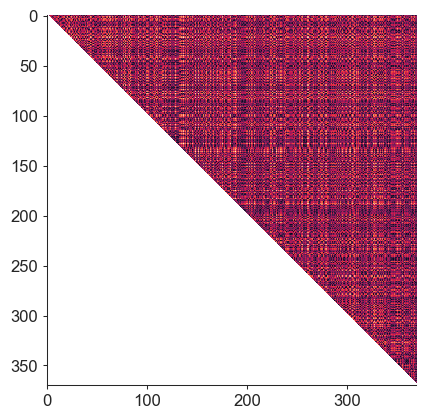

In [25]:
plt.imshow(pairwise_dist)

(0.0, 104.99846187651066)

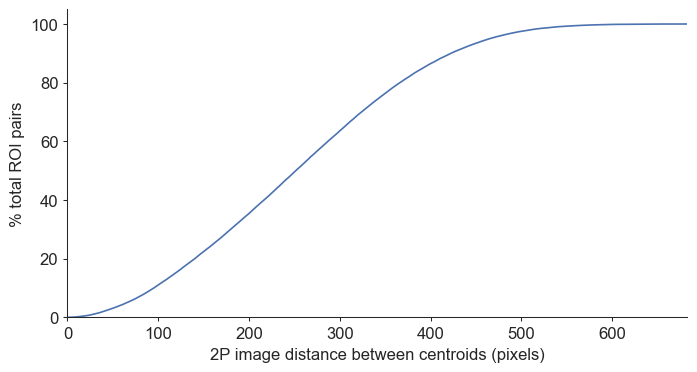

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))

dist_range = np.arange(0, pairwise_dist.max())
y = [(pairwise_dist < d).mean()*100 for d in dist_range]

ax.plot(dist_range, y)
ax.set_xlabel("2P image distance between centroids (pixels)")
ax.set_ylabel("% total ROI pairs")
ax.set_xlim(dist_range.min(), dist_range.max())
ax.set_ylim(0, ax.get_ylim()[1])

In [324]:
type(pairwise_dist[0, 313])

numpy.ma.core.MaskedConstant

array([[False,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

r_test: PearsonRResult(statistic=-0.009971956319667278, pvalue=0.1485285798550851)
ks_near_far: KstestResult(statistic=0.02012323909620517, pvalue=0.09237991060702844, statistic_location=0.4190966120007916, statistic_sign=-1)


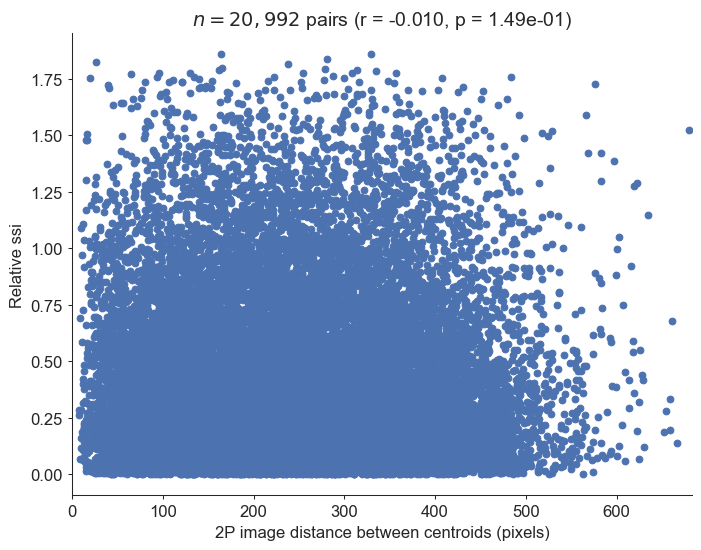

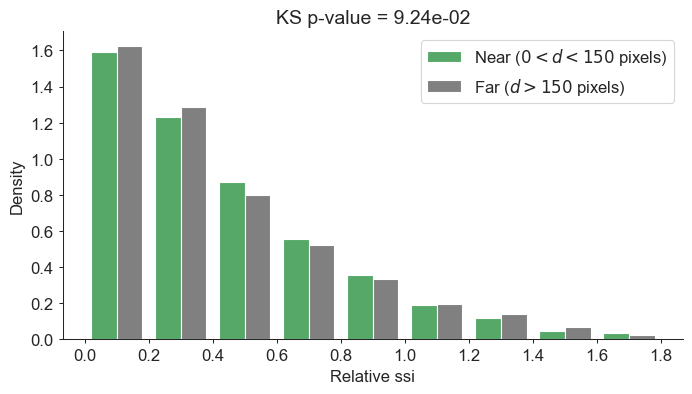

In [49]:
metric = "ssi"
# metric = "dgf_pref_dir_mean"
responsiveness = ("dgw_frac_responsive_trials", 0.5)

xy, metric_values = [], []
xyz = []

for plane in session.get_planes():
    depth = session.get_plane_depth(plane)
    for roi in session.get_rois(plane):
        roi_idx = f"M{session.get_mouse_id()}_{session.get_column_id()}{session.get_volume_id()}_{plane}_{roi}"
        if roi_idx not in metrics.index: continue
        if metrics.at[roi_idx, "is_ignored_duplicate"]: continue
        roi_mask = session.get_roi_image_mask(plane, roi)
        y_ctr, x_ctr = np.mean(np.where(roi_mask), axis=1)
        if metrics.at[roi_idx, responsiveness[0]] >= responsiveness[1]:
            xy.append([x_ctr, y_ctr])
            xyz.append([x_ctr, 10000*depth, y_ctr]) # make depth distance svery large so ROIs in different planes are separated
            metric_values.append(metrics.at[roi_idx, metric])
    
    # break

pairwise_dist = scipy.spatial.distance_matrix(xy, xy)
pairwise_dist = scipy.spatial.distance_matrix(xyz, xyz)
pairwise_dist[np.tril_indices_from(pairwise_dist)] = np.nan
pairwise_dist[pairwise_dist > 1000] = np.nan
pairwise_dist = np.ma.masked_invalid(pairwise_dist)


# Plot delta metric vs. distance
fig, ax = plt.subplots(figsize=(8, 6))

pair_distances, delta_metrics = [], []
for i in range(pairwise_dist.shape[0]):
    for j in range(i+1, pairwise_dist.shape[1]):
        if pairwise_dist.mask[i, j]:
            # This is an invalid pair
            continue
        
        d = pairwise_dist[i, j]
        delta_metric = abs(metric_values[i] - metric_values[j])

        if "pref_dir" in metric:
            delta_metric = delta_metric % 180
            delta_metric = min(delta_metric, 360-delta_metric)

        pair_distances.append(d)
        delta_metrics.append(delta_metric)

pair_distances = np.array(pair_distances)
delta_metrics = np.array(delta_metrics)
r_test = scipy.stats.pearsonr(pair_distances, delta_metrics)

ax.scatter(pair_distances, delta_metrics, color="b")
# at.density_scatter(pair_distances, delta_metrics, ax=ax, alpha=0.25) # Slow for large numbers of ROIs
ax.set_xlabel("2P image distance between centroids (pixels)")
ax.set_ylabel(f"Relative {metric}")
ax.set_xlim(dist_range.min(), dist_range.max())
# ax.set_ylim(0, ax.get_ylim()[1])
ax.set_title(f"$n = {len(pair_distances):,}$ pairs (r = {r_test.statistic:.3f}, p = {r_test.pvalue:.2e})")
print("r_test:", r_test)


# Plot number pairs vs. delta metric bin
fig, ax = plt.subplots(figsize=(8, 4))
bins = np.arange(0, 2, 0.2) # for SSI
# bins = np.arange(0, 180+30, 30)
near_distance = 150
near_distribution = delta_metrics[pair_distances < near_distance]
far_distribution = delta_metrics[(pair_distances > near_distance) & (pair_distances < 600)]

ks_near_far = scipy.stats.ks_2samp(near_distribution, far_distribution)

# sns.histplot(near_distribution, bins=bins, ax=ax_near, color="b")
ax.hist([near_distribution, far_distribution], bins=bins, density=True, color=("g", "gray"), label=(f"Near ($0 < d < {near_distance}$ pixels)", f"Far ($d > {near_distance}$ pixels)"))
ax.set_title(f"KS p-value = {ks_near_far.pvalue:.2e}")
ax.set_xlabel(f"Relative {metric}")
ax.set_ylabel("Density")
ax.set_xticks(bins)
ax.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

print("ks_near_far:", ks_near_far)
